In [1]:
import json
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.signal import savgol_filter

addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Bobak/'
if not os.path.exists(addressPrefix):
    addressPrefix='C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/Bobak/'

In [5]:
def loadingDataReader(fileAddress,parameter):
    try:
        jsonFile = open(fileAddress, )
        data = json.load(jsonFile)

        dateList=[]
        timeList=[]
        valList=[]
        for i in data:
            for j in data[i]:
                timeTemp=j["time"]
                timeTemp=int(timeTemp[0:2])*3600+int(timeTemp[3:5])*60+int(timeTemp[6:8])
                timeList.append(timeTemp)

                dateTemp=i
                dateTemp = datetime.strptime(dateTemp, '%m-%d')+relativedelta(years=+121)
                dateTemp=dateTemp.timetuple().tm_yday
                dateList.append(dateTemp)
                valList.append(float(j["value"]))
        jsonFile.close()
    except:
        print("An exception occurred")

    parList = []
    for i in range (0,len(dateList)):
        parList.append(parameter)

    return dateList,timeList,valList,parList

def loadingDataAux(fileAddress,parameter,allDate,allTime,allVal,allPar):
    fileAddress=os.path.normpath(fileAddress)
    [tempDate,tempTime,tempVal,tempPar]=loadingDataReader(fileAddress,parameter)
    allDate.extend(tempDate)
    allTime.extend(tempTime)
    allVal.extend(tempVal)
    allPar.extend(tempPar)
    print(parameter," is done")

    return allDate,allTime,allVal,allPar

def dataResEnhancer(df):
    gapLength=1
    df=df.sort_values(by=['Parameter', 'Date','Time'])
    gapList=[]

    highResSensor=['Acc','EDA','HR','Temp','CGM']
    for sensor in highResSensor:
        newQuery=df[df['Parameter']==sensor]
        for counter in range(0,len(newQuery)-1):
            if newQuery.iloc[counter+1,0]==newQuery.iloc[counter+1,0]:
                if newQuery.iloc[counter+1,1]-newQuery.iloc[counter,1]>gapLength:
                    gapList.append([newQuery.iloc[counter,0],newQuery.iloc[counter,1],newQuery.iloc[counter+1,1],newQuery.iloc[counter,3]])
    appendedData=[]
    for element in gapList:
        duration= element[2]-element[1]
        for counter in range(0,int(duration/gapLength)):
            appendedData.append([element[0],element[1]+(counter+1)*gapLength,float('nan'),element[3]])

    df = df.append(pd.DataFrame(appendedData,columns=['Date','Time','Value','Parameter']),ignore_index = True)
    df=df.sort_values(by=['Parameter','Date','Time'])

    df=df.interpolate(method='linear')
    return df

def dataCleaner(df):
    i = df[df.Date == 30].index #first data and noisy
    df=df.drop(i)

    i = df[df.Date == 40].index #Partial E4
    df=df.drop(i)

    i = df[df.Date == 41].index #No E4
    df=df.drop(i)

    i = df[df.Date >= 42].index #CGM becomes too noisy at the end of the study
    df=df.drop(i)

    return df

def dataAmputator(df):
    amputations=[[31,38290,39010],[31,61937,62638],[31,66226,71099],
              [32,58667,59563],[32,63875,63902],
              [33,25127,34731],[33,57996,58812],
              [34,25556,30763],[34,58736,59877],[34,66069,66092],
              [35,27945,31416],[35,57283,58147],
              [36,29865,33926],[36,59231,60096],
              [37,26911,32544],[37,40214,41380],
              [38,26707,34560],[38,38172,39273],
              [39,31053,35335],[39,57408,58655]]

    for amputation in amputations:
        i=df[(df['Date']==amputation[0]) & (df['Time']>=amputation[1]) & (df['Time']<=amputation[2])].index
        df=df.drop(i)

    return df

def loadingData(addressPrefix):
    if not os.path.exists(addressPrefix+'Result-in.csv'):
        allDate=[]
        allTime=[]
        allVal=[]
        allPar=[]

        sensorList=[['intraday-ACC_E4.json','Acc'],['intraday-calories.json','Cal'],
                    ['intraday-EDA_E4.json','EDA'],['intraday-HR_E4.json','HR'],
                    ['intraday-steps.json','Step'],['intraday-TEMP_E4.json','Temp'],
                    ['intraday-glucose.json','CGM']]

        sensorList=[['intraday-TEMP_E4.json','Temp']]

        for element in sensorList:
            fileAddress=addressPrefix+element[0]
            allDate,allTime,allVal,allPar=loadingDataAux(fileAddress,element[1],allDate,allTime,allVal,allPar)

        dfOriginal = pd.DataFrame(list(zip(allDate,allTime,allVal,allPar)),
                          columns =['Date','Time','Value','Parameter'])
        dfOriginal=dfOriginal.sort_values(by=['Parameter','Date','Time'])
        dfOriginal.to_csv(addressPrefix+'Result-original.csv', header=True,index=False)
        dfInterp=dataCleaner(dfOriginal)
        dfInterp=dataResEnhancer(dfInterp)
        dfInterp=dataAmputator(dfInterp)
        dfInterp.to_csv(addressPrefix+'Result-interpolated.csv', header=True,index=False)
    else:
        dfOriginal=pd.read_csv(addressPrefix+'Result-original.csv')
        dfInterp=pd.read_csv(addressPrefix+'Result-interpolated.csv')
    return dfOriginal,dfInterp

dfOriginal,dfInterp=loadingData(addressPrefix)

Temp  is done
Int64Index([38290, 38291, 38292, 38293, 38294, 38295, 38296, 38297, 38298,
            38299,
            ...
            39001, 39002, 39003, 39004, 39005, 39006, 39007, 39008, 39009,
            39010],
           dtype='int64', length=721)
Int64Index([61937, 61938, 61939, 61940, 61941, 61942, 61943, 61944, 61945,
            61946,
            ...
            62629, 62630, 62631, 62632, 62633, 62634, 62635, 62636, 62637,
            62638],
           dtype='int64', length=702)
Int64Index([66226, 66227, 66228, 66229, 66230, 66231, 66232, 66233, 66234,
            66235,
            ...
            66252, 66253, 66254, 66255, 66256, 66257, 66258, 66259, 66260,
            66261],
           dtype='int64', length=4875)
Int64Index([140229, 140230, 140231, 140232, 140233, 140234, 140235, 140236,
            140237, 140238,
            ...
            141116, 141117, 141118, 141119, 141120, 141121, 141122, 141123,
            141124, 141125],
           dtype='int64', lengt

c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


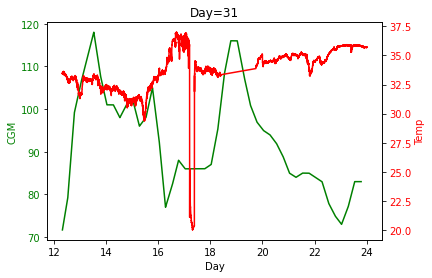

c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


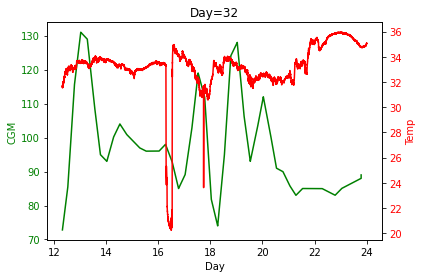

c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


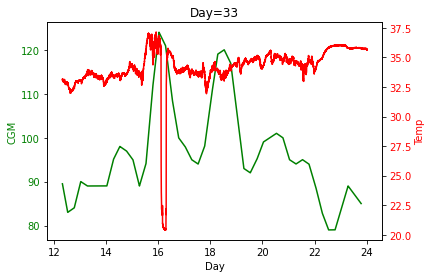

c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


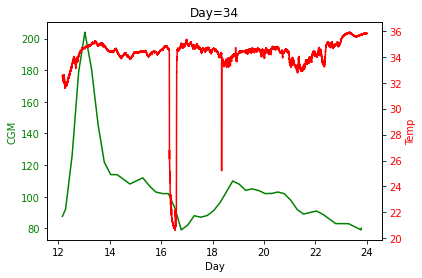

c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


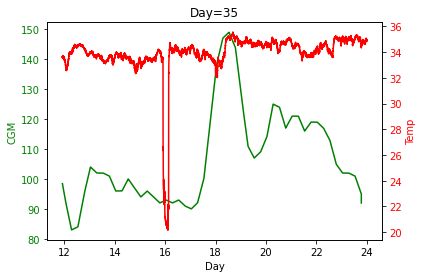

c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


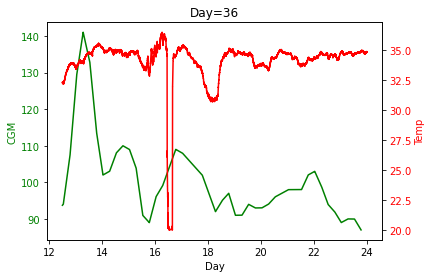

c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


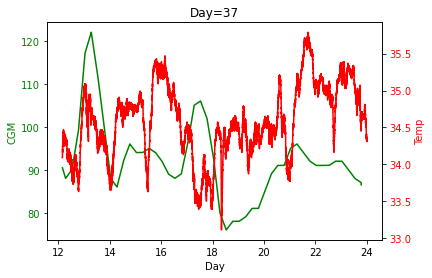

c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


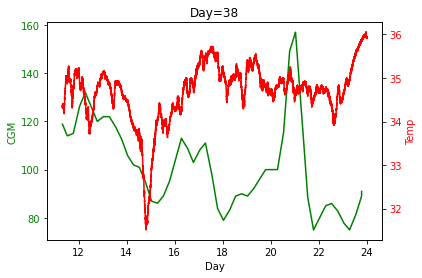

c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\sorus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


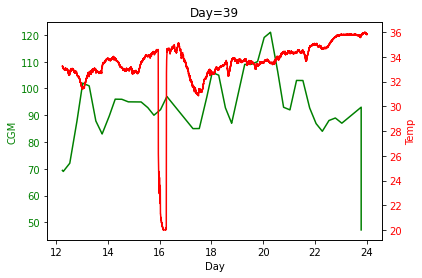

In [19]:
windowDuration=23.7
lagTimes=np.arange(-3,3,0.5)
lagTimes=[0]
mealTimes=[12.33,12.33,12.33,12.16,11.92,12.5,12.16,11.33,12.25]
plotFlag=True
plotParamter='Temp'



pearsons=[]

days=dfInterp['Date']
days=days.values.tolist()
days=set(days)
days=list(days)
days.sort()
for lagTime in lagTimes:
    for counter,day in enumerate(days):
        mealTime=mealTimes[counter]
        inqueryCGM=dfInterp[dfInterp['Date']==day]
        inqueryCGM.iloc[:,1]=inqueryCGM.iloc[:,1]/3600
        inqueryCGM=inqueryCGM[inqueryCGM['Parameter']=='CGM']
        inqueryCGM=inqueryCGM[inqueryCGM['Time']<=mealTime+windowDuration]
        inqueryCGM=inqueryCGM[inqueryCGM['Time']>=mealTime]


        inqueryVar=dfInterp[dfInterp['Date']==day]
        inqueryVar.iloc[:,1]=inqueryVar.iloc[:,1]/3600
        inqueryVar=inqueryVar[inqueryVar['Parameter']==plotParamter]
        inqueryVar=inqueryVar[inqueryVar['Time']<=mealTime+windowDuration+lagTime]
        inqueryVar=inqueryVar[inqueryVar['Time']>=mealTime+lagTime]


        if plotFlag:
            fig, ax1 = plt.subplots ()
            ax2 = ax1.twinx ()

            inqueryCGM.plot(ax=ax1,x='Time',y='Value',color='green')
            ax1.tick_params (axis='y', labelcolor='green')

            inqueryVar.plot(ax=ax2,x='Time',y='Value',color='red')
            ax2.tick_params (axis='y', labelcolor='red')

            ax1.set_ylabel('CGM')
            ax1.set_xlabel('Day')
            ax1.yaxis.label.set_color("green")

            ax2.set_ylabel(plotParamter)
            ax2.yaxis.label.set_color("red")

            plt.savefig(addressPrefix+'figure'+str(day)+'.jpg')
            plt.title("Day="+str(day))
            ax1.get_legend().remove()
            ax2.get_legend().remove()
            plt.show()

        # corr, pval = pearsonr(CGMNew, varNew)
        # print("Pearson ratio=", corr, "p-val=",pval)
        # pearsons.append([lagTime,day,corr, pval])
# pearsons=np.asarray(pearsons)
# for i,lagTime in enumerate(lagTimes):
#     for j,day in enumerate(days):
#         print(pearsons[i*9+j])
#     print("----------------------")
#     print(np.mean(pearsons[i*9:i*9+9,2]))
#     print("----------------------")